In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
         
    
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import linearReg_helper as lrh
%aimport linearReg_helper


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split 


# Overview

The purpose of this notebook is two-fold
- to introduce a systematic approach to problem solving in Machine Learning
- to introduce our first model for Supervised Machine Learning: Linear Regression

We will 
- introduce our systematic approach
- and illustrate it using Linear Regression as the chosen model

# What is the "Recipe" for Machine Learning

We will define a methodical approach to solve problems using Machine Learning.

This is the *Recipe for Machine Learning*

<table>
    <tr>
        <th><center>Recipe for Machine Learning</center></th>
    </tr>
    <tr>
        <td><img src="images/W1_L3_S4_ML_Process.png" width="100%"></td>
    </tr>
</table>
​

There are no short-cuts !

Each step in the Recipe  both prepares you for the next and, crucially, gives you *deeper insight*
which improves the result.

# Plan

We will illustrate *some* of the major steps in the Recipe.

The prediction problem we are solving is relatively simple
- so some steps of the Recipe won't be applicable
  

<div class="alert alert-block alert-danger">
    <b>Disclaimer:</b> 
    <br>
    The purpose of this lecture is <i>not</i> to make you an expert in sklearn. 
    <br>
    It is to introduce you to concepts that you can apply no matter what toolkit you use in the future.
    
</div>

# Recipe step A: Get the data

## Frame the problem

The first step in the Recipe is
- to define the problem !
- Why is it important ?
- Define terms


We are going to define a "toy" problem (probably unrealistic, but it will illustrate concepts)

>We are in the real-estate business.
>
>Our task: given a house/apartment for sale: predict the selling price (to advise the seller/buyer)



Our goal is *informed* prediction.

So our first step is
- to *hypothesize* one or more features that is predictive of Price
- using your intuition (or conducting research) as to what may drive apartment/house prices
    - size
    - location
    - amenities (kitchen, bath, pool)

Once we decide on the features we perform the **Get the data** step
- gather *labeled* examples
    - pairs of: $\langle \x, \y \rangle$
        - vector of features $\x$, target (Price) $\y$
- which we will use to train a model for prediction  

The difficulty of this step may be under-appreciated
- *finding* data is not always easy
- Interesting data is scattered: requires collection, merging
- Supervised Learning requires labeled data;
    - where do the labels come from ?
- *extracting* data from its source (e.g., a web page) may involve specialized skills (*web-scraping*)

# Get the data

As a gross over-simplification
- we will use a single feature: Size
- and we will give you the $\langle \text{Size}, \text{Price} \rangle$ pairs via a method within a helper class

In [5]:
lr_demo = lrh.LinReg()

# Some options to configure the data
rho, sigma_mult = 0, 20

# Generate the data
df = lr_demo.gen_data(samples=300, rho=rho, sigma_mult=sigma_mult)

# Restrict the view to features used in the first experiment
df_initial = df[ ["x_1", "y"] ]

For illustration
- the full dataset (DataFrame `df`) has all the features (including the ones we only use in the future)
- for now: we will only look at the relevant features (DataFrame `df_initial`)

Column
- "x_1" is our first feature: Size
- "y" is our target: Price



## Look at the data

Always put your eyes on the data !
- You will learn about its "shape":
    - tabular ?  What are the attribute names ?
    - What are the types of the attributes ? Numeric ? Text ?
    
Let's look at the first few examples.

In [6]:
df_initial.head()

,x_1,y
0,0.000000,104.242391
1,0.033445,96.073816
2,0.066890,112.187158
3,0.100334,124.460065
4,0.133779,96.855848


- You will learn about potential data problems
    - missing data
    - strange values
    
Don't even try to do anything with your data until you have at least the most basic understanding by
performing an inspection.

We can get some summary information:

In [7]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
x_1    300 non-null float64
y      300 non-null float64
dtypes: float64(2)
memory usage: 4.8 KB


From the above
- we see the number of examples
- that the feature and target are both numeric (float)
- **no** missing data
    - number of non-null equals number of examples
    
We can also calculate statistics of the columns:

In [8]:
df_initial.describe()

,x_1,y
count,300.000000,300.000000
mean,5.000000,210.010372
std,2.901229,97.074015
min,0.000000,76.624519
25%,2.500000,126.719483
50%,5.000000,189.308862
75%,7.500000,282.030633
max,10.000000,430.461341


We see a statistical summary above ?

What "units" are the features/targets denominated in ?
- "x_1" (Size): range $0$ to $10$
    - clearly not Area
    - some scale from smallest (0) to largest (10)
        - unimportant for our illustration
        - but **important** in order to interpret
            - the feature
            - its associated parameter
                - increment in Price for a unit change in feature

- "y" (Price)
    - Units
        - "hundreds of thousands" of currency
        - number of Bitcoin ?
        
Again: unimportant for our illustration
- but important for the end-user

## Define a Performance Measure

Our model "learns" from training data, so we might expect it to predict well on training examples
- the training examples are *in sample*: used by the model to learn $\Theta$

How well should I expect the model to predict on  examples not encountered during training ?
- "test" examples never seen during training, called *out of sample* examples

We define a *Performance Measure* to measure how well the model performs out of sample.

A Performance Measure can be thought of as the promise you make
- to a client/customer/boss
- on how well your model will perform on arbitrary, yet to be seen examples (non-training, out-of-sample)

In order for you to have confidence in your promise
- you evaluate the Performance Measure on *out of sample* examples
- using the out of sample examples *once* so that your model doesn't learn from them (i.e., become in-sample)

### Root Mean Square Error: an absolute performance metric

Our problem is to predict continuous values (Regression task).

- A common performance measure for Regression is the Root Mean Square Error (RMSE):

$$\textrm{RMSE}(\y, \hat{\y}) = \sqrt{ { 1\over{m}} \times \sum_{i=1}^m { ( \y^\ip - \hat{\y}^\ip)^2} }$$

Our goal is to minimize the RMSE by making each prediction $\hat{\y}^\ip$ close to the true value $y^\ip$.

n.b., we will sometimes ignore the square root
$$\textrm{MSE}(\y, \hat{\y}) = \text{RMSE}(\y, \hat{\y})^2$$


### Performance Measure versus Loss Function

There may some confusion between the Performance Measure and Loss functions
- they are both evaluated over a set of examples
- they both measure performance of some sort

To be clear
- the Loss function is evaluated over the *training* examples
    - it is the objective that we try to minimize
    - by finding optimal $\Theta$
- the Performance Measure is evaluated over the *test* examples
    - a prediction of out of sample performance
    - using test examples as a proxy for examples to be seen in the future


To illustrate, let
- $\X$ denote our set of training examples, $\x^\ip \in \X$
- $\Xt$ denote a set of test examples (out of sample: not used in training), $\xt^\ip \in \Xt$


<table>
    <tr>
        <th><center>Loss on  <i>Training example</i></center></th>
    </tr>
    <tr>
        <td><img src="images/W1_L4_s15_Intro_training.jpg" width="70%"></td>
    </tr>
</table>
​

<table>
    <tr>
        <th><center>Performance on  <i>Test example</i></center></th>
    </tr>
    <tr>
        <td><img src="images/W2_L2_S15_Performance_measure.png" width="70%"></td>
    </tr>
</table>
​

- A Performance Measure
    - is a property of the *problem* (not the model used to solve the problem)
    - you may have more than one Performance Measure
        - each expressing some desired quality of the prediction
    - is evaluated *out of sample*, that is, on non-training examples

- The Loss Function
    - is a property of a *model*: it guides a particular model's search for the best $\Theta$
        - different models may have different Loss Functions
            - but the *problem's* Performance Metric is the same
    - is evaluated *in sample*, that is, on training data

## Create a test set

Our Performance Metric is evaluated
- on a test dataset
- derived from our complete dataset
- but **used only once**

We split our complete dataset into
- train dataset
- test dataset



In [9]:
# Separate the features from the target
X = df[ ["x_1", "x_2"]].to_numpy()
y = df[ "y"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   random_state=lr_demo.seed,  
                                   test_size=0.2,  
                                   shuffle=True) 

In [10]:
X.shape, y.shape

((300, 2), (300,))

In [11]:
print("Train: ", X_train.shape, y_train.shape, X_train[:, [0]].shape,
      "\n",
     "Test:",    X_test.shape,  y_test.shape,  X_test[:, [0]].shape)

Train:  (240, 2) (240,) (240, 1) 
 Test: (60, 2) (60,) (60, 1)


In the above
- you can see the number of examples in the train and test datasets
- in the initial model: we will only access the *first* feature

**Note**
- the single feature is a **two**-dimensional ndarray
    - singleton second dimension
- the target is a **one** dimensional ndarray
    - `sklearn` is sensitive (different behavior) when target is 2D with a singleton dimension

**Note**

In the above
- we included a second feature (x_2) to be used in the future
- in real life: you would only be accessing x_1 at this point

# Exploratory Data Analysis

This is one of the key steps of a good Data Scientist.

Besides "seeing" the data, we need to hear it: what is it telling us that may aid prediction

- Any problems with the data that would inhibit learning ?
- Any obviously useful predictive features ?
    - relationship between target and a single feature ?
    - relationship between target and combinations of features ?

Any more complex relationships that may be useful ?
- Relationship *between* features ?
- Relative magnitudes of features ?

Often,  understanding the data intimately can lead to
- transformations of the features that will aid prediction
- improved models

Given a single feature
- at this point, we can only really explore the relationship between feature and target
- in the presence of more than one feature we can examine 
    - the feature/target relationship for each feature
    - the feature/feature relationships

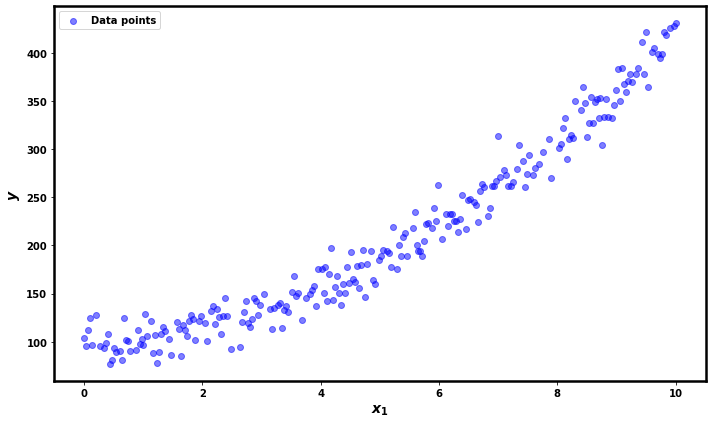

In [12]:
# Create the plot
_= plt.figure(figsize=(10, 6))
_= plt.scatter(X_train[:,0], y_train, color='blue', alpha=0.5, label='Data points')


# Set labels and title
_= plt.xlabel('$x_1$')
_= plt.ylabel('$y$')
_= plt.legend()

# Show the plot
_= plt.tight_layout()
_= plt.show()

At first glance
- the relationship may not be exactly linear
- **but**
    - take small steps
    - start with a simple model
    - try to improve it
    
We will start with the hypothesis
- that a linear relationship between target and feature will suffice
- this suggest Linear Regression as the model to use

# Prepare the data

It is not always the case that the data in "raw" form is adequate for modeling
- Cleanliness
    - dealing with missing data or anomalous values
- Numericalization
    - Converting non-numeric/categorical data into appropriate numbers
- Scaling, normalization
    - putting features on compatible scales
 

A key part of the Prepare the Data step is *feature engineering* or *transformations*
- Creating new, synthetic features from the "raw" features
- Knowing when/how to do this is what separates a good Data Scientist from an average one

In our toy example
- there is no missing data
- no "unclean" data: outliers

We won't perform any *feature engineering* in our first pass at the model
- in our second pass:
    - we will create a second feature
    - derived from x_1

# Train a model

The model is our "predictor": the machine that takes features and produces predictions.

All the prior steps of the recipe were "prep-work": preparing the ingredients (data) for cooking (modeling)

Unlike actual cooking, this step is *iterative*
- Try a simple model, fit it to the data and evaluate the results
- Perform Error Analysis: Examine the results critically
    - Have our changes improved the Loss ? Is the Loss value acceptable ?
    - Is there some commonality among the examples with "bad" predictions ?
        - Can we change the model or perform Feature Engineering to compensate for common errors ?
        - Perform Feature Engineering, modify the model. 
- Repeat !

<table>
    <tr>
        <th><center>Iterative training</center></th>
    </tr>
    <tr>
        <td><img src="images/W2_L2_S27_ML_process_iterate.png"></td>
    </tr>
</table>
​

The iterative nature is often overlooked in the rush to learn as many models as possible.

As we shall see
- The lessons learned from the Error Analysis is how we systematically progress from
    - Simple but poor models
    - To better models of increasing complexity

## Select a model: Linear Regression

Based on our Exploratory Data Analysis
- we hypothesize a linear relationship between Price and Size
- we select the *Linear Regression* model as the *prediction function*

Linear Regression says that our prediction $\hat\y$ is a *linear* function of the features $\x$
$$
\hat\y = \Theta \cdot \x
$$

Remember: the dot product is noting more than the sum of the pair-wise products
- of each feature $\x_j$ with its corresponding parameters $\Theta_j$

For our problem
- predicted target (Price) is a linear function of $\x_1$ (Size)

## Fit the model

To create the prediction function
- we *fit* the model
- to the training examples

That is
- we minimize the Loss Function that is associated with Linear Regression
- over the set of training examples: $( \text{Size}, \text{Price} )$ pairs

The definition of the Loss Function for Linear Regression will be presented shortly.

Here is code for our single-feature model

In [13]:
# Create and fit the linear regression model
model = LinearRegression()

# Note: we access the single feature as X_train[:, [9]] rather than X_train[:, 0] to ensure the result is 2D
# - with a singlteon final dimension, as required by sklearn
_= model.fit(X_train[:,[0] ], y_train)

Easy enough !
- `sklearn` API: all models respond to a method `fit`
    - takes training data
    - sets weights
        - internal variables of the model object

## Validation

The proof is in the pudding
- How does our fitted model perform out of sampe ?
- That is
    - compute the Performance Metric (out of sample)

We show the Performance Metric as part of a plot
- of Predicted values vs True Value
- the 45 degree line is the imaginary line where Predicted and True values are identical

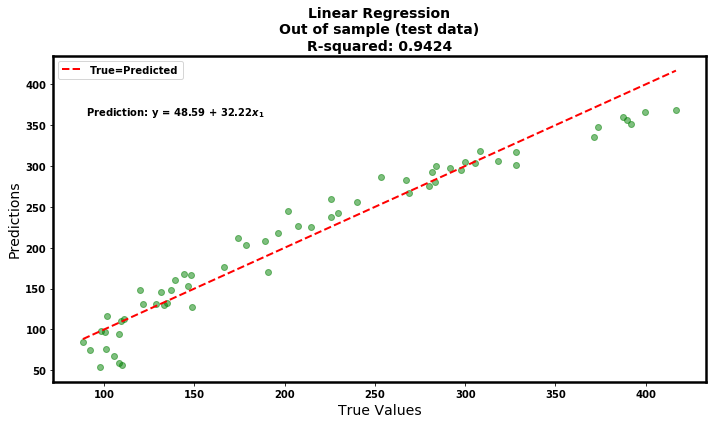

In [14]:
fig, ax =  lr_demo.plot_pred_vs_true(model, y_test, X_test[:,[0] ], feature_names=["$x_1$"], 
                                     title="Linear Regression\nOut of sample (test data)\n")

The Performance Metric is close to 100 %
- Technically
    - our Performance Metric is RMSE
    - we show $R^2$, a related quantity

But observe a systematic mis-estimation
- For extreme values of True $y$ (horizontal axis)
    - our predictions *under-estimate* the True
- For mid-range values of $y$
    - out predictions *over-estimate* the True
    

Since there is only a single feature
- we can also visual the mis-estimation as a function of $x_1$

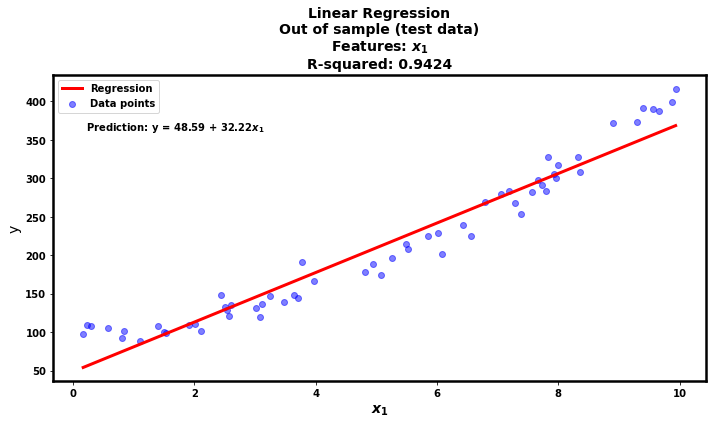

In [15]:
fig, ax = lr_demo.plot(model, y_test, X_test[:,[0] ], feature_names=["$x_1$"], 
                       title="Linear Regression\nOut of sample (test data)\n",
                       showTrue=False)

Observe 
- low and high values of $x_1$ result in *under-estimates* (red fitted line below true target)
- mid-range values of $x_1$ result in *over estimation* (red fitted line above true target)

This is probably not good for business !
- Arbitrage opportunity ?
    - Buy very small and very large homes  from the user of the model (under-priced); re-sell to others at higher, true value
    - Buy mid-size homes from others at True value; sell to user of model (over-priced)  at higher price 

## Error Analysis
 
How good is our model ?

Our ultimate measure
- evaluate the Performance Metric on out of sample data

We observed a systematic mis-estimation.

How do we remove this systematic estimation bias ?

In general
- the Loss Function and Performance Metric are distinct 
    - identical in the case of Linear Regression
- changing the model
    - only *directly* affects the Loss Function


But we can also perform **Error Analysis**
- examine the success of the model
- on each *training* example
- comparing prediction to target

We can hope that removing the systematic estimation bias from the Loss (in sample)
- will lead to it being removed from the Performance Metric (out of sample)



Here is a visualization that may be helpful for Error Analysis

It is nearly identical to the plot we used for the Performance Metric
- Red line: the ideal, where Predicted = True
- True value (green points)
- **But** here we are  using the **training** examples
    - our previous plot used **test** examples

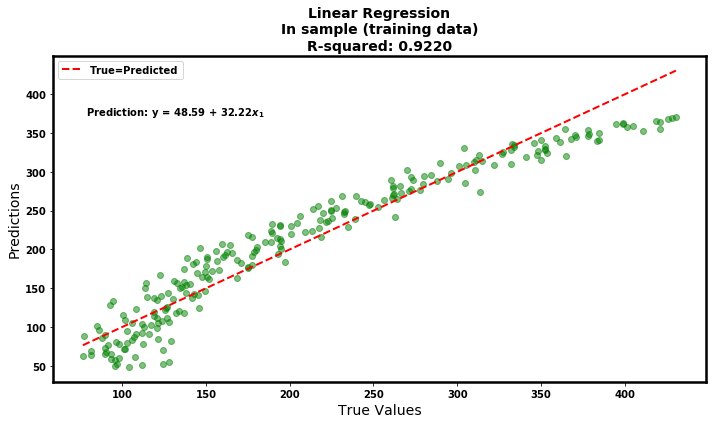

In [16]:
fig, ax =  lr_demo.plot_pred_vs_true(model, y_train, X_train[:,[0] ], feature_names=["$x_1$"], 
                                     title="Linear Regression\nIn sample (training data)\n")

We can see a similar pattern of mis-estimation in the training dataset as we saw in the test dataset.
- to be expected if the two *empirical* datasets are derived from the same underlying distribution

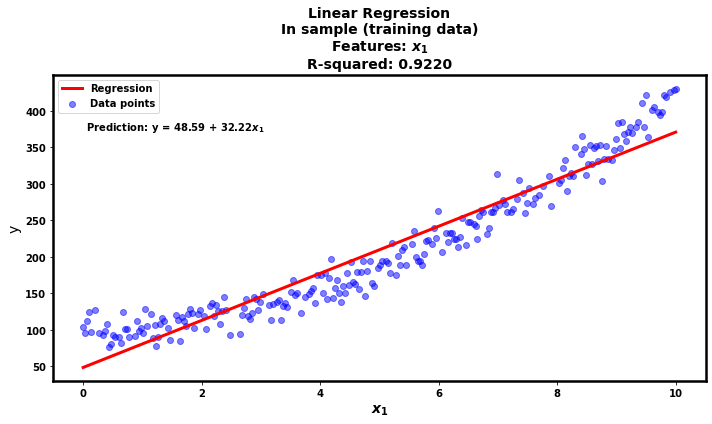

In [17]:
fig, ax = lr_demo.plot(model, y_train, X_train[:,[0] ], feature_names=["$x_1$"], 
                       title="Linear Regression\nIn sample (training data)\n",
                       showTrue=False)

**Don't be confused**

Linear Regression is a special case where
- the Loss Function (re-expressed as $R^2$)
- the Performance Metric (re-expressed as $R^2$)

are the same !

This is not always the case
- Loss function is evaluated on **training** dataset (in sample)
- Performance Metric is evaluated on **test** dataset (out of sample)

### What is the Error Analysis telling us ?

The $R^2$ (Loss Function proxy) is quite good
- almost 100%

But this is only a **summary** measure
- good on average
- but perhaps bad in a systematic way !

The Error Analysis reveals a potentially dangerous flaw in our hypothesis
- Price (y) 
    - is *under-estimated* for
        - low Sizes ($x_1$)
        - high Sizes ($x_1$)
    - is *over-estimated* for
        - intermediate values of Size

**Never be satisfied** with just a summary measure
- examine per-example losses

The systematic pattern of errors suggest a need to refine our hypothesis
- of a single feature, linear relationship between Price and Size

## Iterate: Linear Regression with higher order features

The Error Analysis we performed on our first model (single non-constant feature) suggested a need for improvement.

Two types of improvement come to mind
- Hypothesis iteration: try  a different model
    - different *functional form* for the prediction: non-linear model
    - models without functional forms (Decision Tree)
    
- Feature iteration: change/add to the features of the current model
    - adding a previously discarded feature
    - creating a synthetic feature


We go back to our Exploratory Data Analysis
- which suggested some curvature in the relationship between y and $x_1$

Rather than changing to a non-linear model
- we will use *feature engineering* (feature iteration)
- to add a *feature* capturing curvature
- while keeping the functional form linear !

How can this be achieved ?

**Answer**

Add a second feature: $x_1^2$

Our (first-order) linear model was

$$ \y = \Theta_0 * 1 + \Theta_1  \x_1 $$

We can create a *second order* linear model by adding a feature $x_1^2$:

$$ \y = \Theta_0*1 + \Theta_1  \x_1 + \Theta_2  \x_1^2$$

The model is still linear in $x_1$ and 
$x_1^2$
- can be expressed as a dot product
    $$y = \Theta \cdot \x$$
    
It is 
- a linear model
    - so can use Linear Regression as the model
- whose terms are polynomial in a common feature

In [18]:
# Add an x_1^2 column to X_train AND X_test
X_train_with_sq = np.column_stack( (X_train[:, 0], X_train[:, 0]**2) )
X_test_with_sq = np.column_stack( (X_test[:, 0], X_test[:, 0]**2) )

# Fit the model
model = LinearRegression()
_= model.fit(X_train_with_sq, y_train)

In the above
- the first feature is `X_train[:, 0]`
- we added a second feature `X_train[:, 0]**2`
    - the square of the first feature
    

**Also notice**
- We have performed *feature engineering*
    - Added a feature
- Feature engineering is applied
    - to **both** training and test examples
        - if we trained on two features
        - the model expects these same two feature in test (out of sample) examples

Validation on the new model:
- how is our new out of sample Performance ?

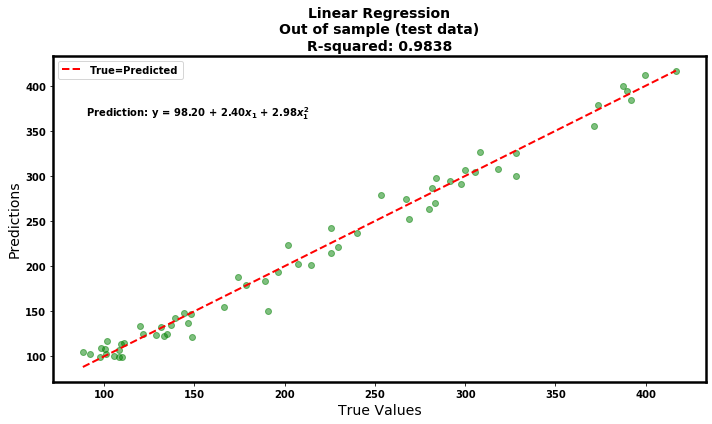

In [19]:
fig, ax =  lr_demo.plot_pred_vs_true(model, y_test, X_test_with_sq, feature_names=["$x_1$", "$x_1^2$"], 
                                     title="Linear Regression\nOut of sample (test data)\n")

The Performance Metric has increased !
- adding the new feature helped

We also no longer see the systematic mis-estimation.

We can also visualize this as a function of one feature ($x_1$)

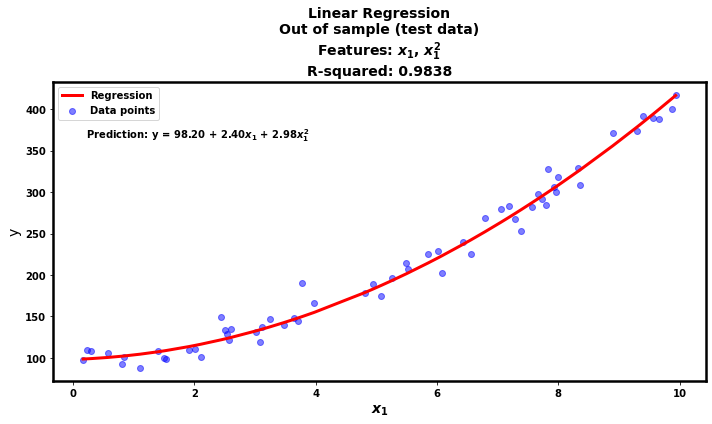

In [20]:
fig, ax = lr_demo.plot(model, y_test, X_test_with_sq, feature_names=["$x_1$", "$x_1^2$"],
                       title="Linear Regression\nOut of sample (test data)\n",
                       showTrue=False)
 


Let's perform Error Analysis on this revised model

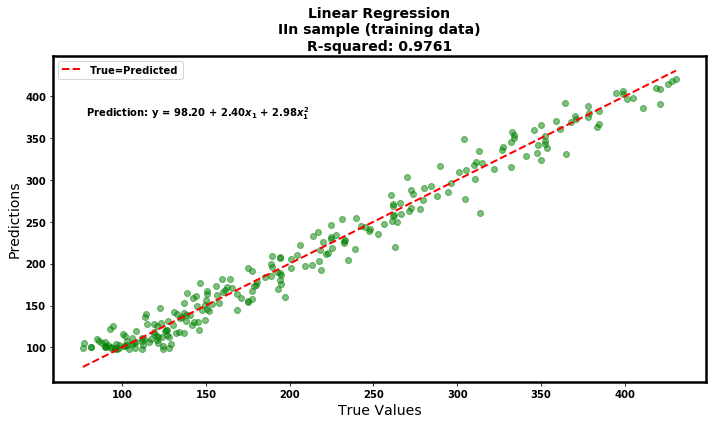

In [21]:
fig, ax =  lr_demo.plot_pred_vs_true(model, y_train, X_train_with_sq, feature_names=["$x_1$", "$x_1^2$"], 
                                     title="Linear Regression\nIIn sample (training data)\n")

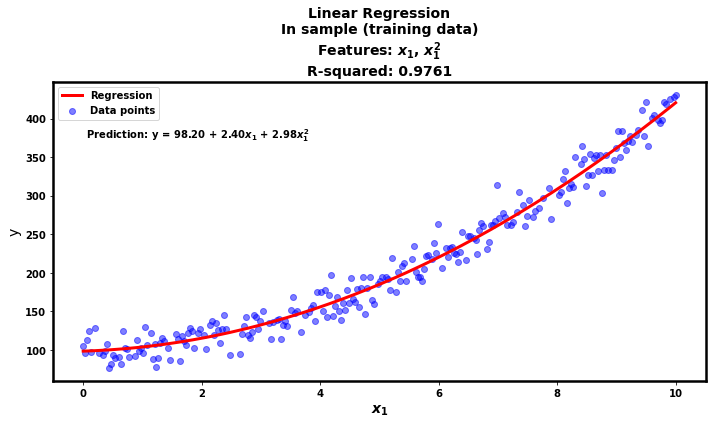

In [22]:
fig, ax = lr_demo.plot(model, y_train, X_train_with_sq, feature_names=["$x_1$", "$x_1^2$"],
                       title="Linear Regression\nIn sample (training data)\n",
                       showTrue=False)
 

Notice
- the decrease in the Loss Function
    - expressed as increase in $R^2$
- compared to the first model

There is no obvious systematic pattern in the errors.

### How is our model linear when the plot is curved ?

You may be uncomfortable seeing a curve when we call our model "linear".

It is *linear* in the features $x_1$ and $x_1^2$
- That is: it can be written as a dot product
 linear in 
    - $y = \Theta \cdot \x$

The fact that one feature ($x_1^2$) depends on another ($x_1$) does not alter the fact that the form is linear

You see a curve because
- because we are plotting $\hat\y$ against **only one** of the features
    - it is **not** linear in $x_1$ alone

Let's plot the fitted surface against both features.

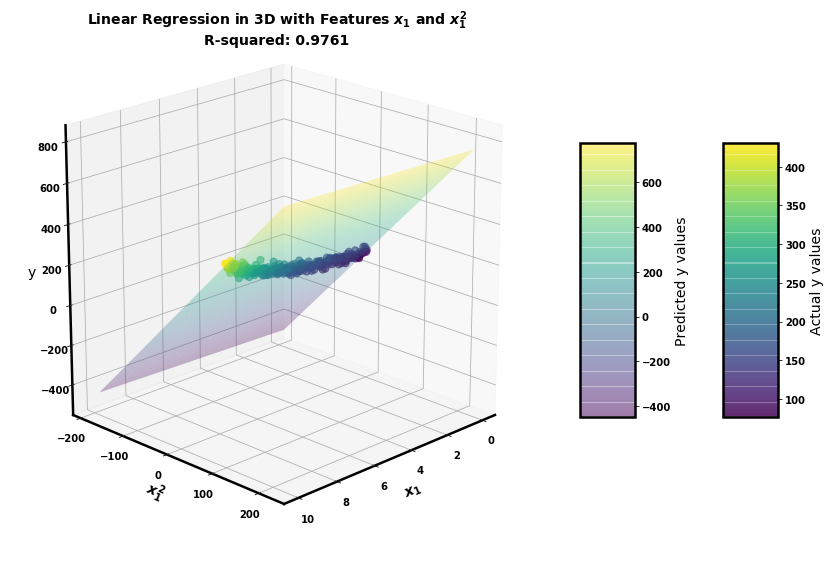

Intercept: 98.2032
Coefficient for x: 2.4046
Coefficient for x^2: 2.9834


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Calculate R-squared
y_pred = model.predict(X_train_with_sq)
r_squared = r2_score(y_train, y_pred)

# Create a mesh grid for plotting
xx, xx_squared = np.meshgrid(np.linspace(X_train_with_sq[:, 0].min(), X_train_with_sq[:, 0].max(), 50),
                             np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 50))

# Predict using the model
Z = model.predict(np.column_stack((xx.ravel(), xx_squared.ravel()))).reshape(xx.shape)

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
scatter = ax.scatter(X_train_with_sq[:, 0], X_train_with_sq[:, 1], y_train, c=y_train, cmap='viridis', s=50, alpha=0.6)

# Plot the regression plane
surf = ax.plot_surface(xx, xx_squared, Z, alpha=0.3, cmap='viridis')

# Set labels and title
_= ax.set_xlabel('$x_1$')
_= ax.set_ylabel('$x_1^2$')
_= ax.set_zlabel('y')
_= ax.set_title(f'Linear Regression in 3D with Features $x_1$ and $x_1^2$\nR-squared: {r_squared:.4f}')

# Adjust the viewing angle
_= ax.view_init(elev=20, azim=45)

# Add colorbars
_= fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Actual y values')
_= fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Predicted y values')

_= plt.tight_layout()
_= plt.show()

# Print model coefficients
print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficient for x: {model.coef_[0]:.4f}")
print(f"Coefficient for x^2: {model.coef_[1]:.4f}")


The fitted surface above 
- is a hyperplane
- in $x_1$ and $x_1^2$

## When to stop iterating

Adding second order features resulted in a much better model
- both in sample
- and out of sample

So our "fix" to the first (single feature) model was successful.

But this will not always be the case
- perhaps our hypothesis of a Linear functional form is wrong
- perhaps more features are needed

We should consider ourselves Scientists conducting experiments
- Propose a theory
    - gather data
    - test the theory
- Revise/Improve the current theory **OR** discard it and start with a different theory

Considering our success at adding the second features
- At this point
- we may ask whether further improvement is needed
    - continue iterating
- or is the model sufficient for our purposes
    - stop iterating

We encourage you to do a Deeper Dive by examining the topic of [Bias and Variance](Bias_and_Variance.ipynb)

## Continue iterating: the case of a missing feature

You may be disappointed that our fit is not perfect.
- we could try adding higher order polynomial features

Sometimes, this is because
- our model is **missing a feature**
    - we need to improve our hypothesis
    - gather data for this new feature

In our "Get the data" step
- we indicated the presence of a second feature $x_2$
    - which we hid from view until now
    
Let's imagine that we hypothesized that this was a useful feature and added it to our model.

In [24]:
# Add an x_1^2 column to X_train and X_test
X_train_full = np.column_stack( (X_train[:, 0], X_train[:, 0]**2, X_train[:,1]) )
X_test_full  = np.column_stack( (X_test[:, 0],  X_test[:, 0]**2 , X_test[:,1]) )

# Fit the model
model = LinearRegression()
_= model.fit(X_train_full, y_train)

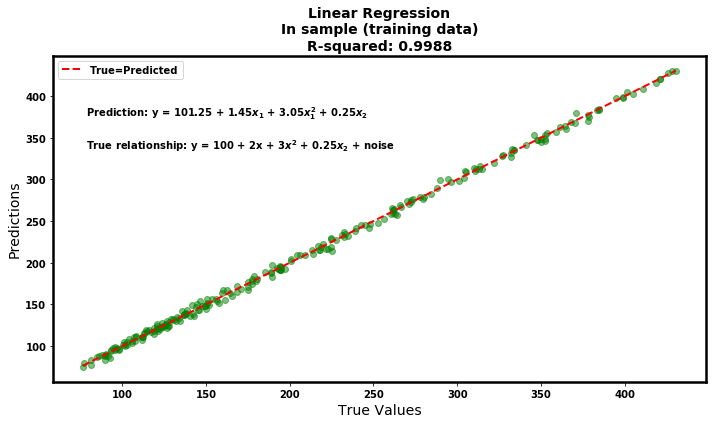

In [25]:
fig, ax =  lr_demo.plot_pred_vs_true(model, y_train, X_train_full, feature_names=["$x_1$", "$x_1^2$", "$x_2$"], showTrue=True,
                                     title="Linear Regression\nIn sample (training data)\n")

Since there is a second feature ($x_2$)
- we really need to plot with 2 (or 3) feature dimensions
- we take the liberty of plotting against just the $x_1$ feature
    - so we no longer see a straight line

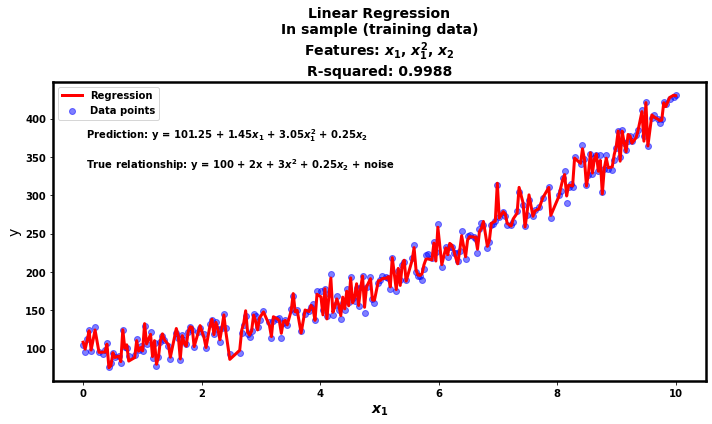

In [26]:
fig, ax = lr_demo.plot(model, y_train, X_train_full, feature_names=["$x_1$", "$x_1^2$", "$x_2$"],
                       title="Linear Regression\nIn sample (training data)\n",
                       showTrue=True)

Almost perfect $R^2$ !

Similar results out of sample:

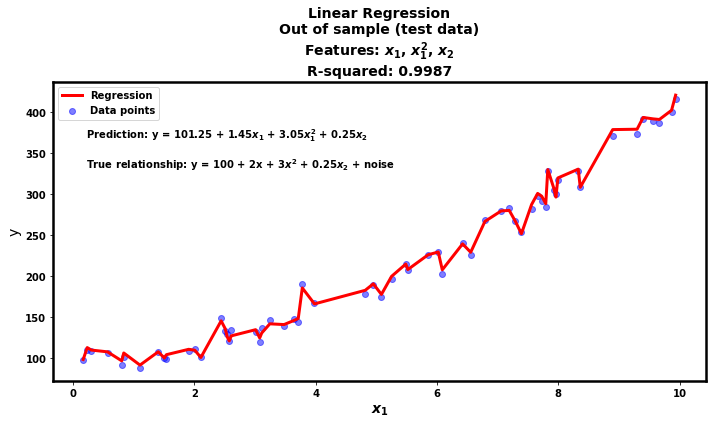

In [27]:
fig, ax = lr_demo.plot(model, y_test, X_test_full, feature_names=["$x_1$", "$x_1^2$", "$x_2$"],
                       title="Linear Regression\nOut of sample (test data)\n",
                       showTrue=True)

### Aside: Near perfect fit but our weight estimates don't match true values

In the plots above, we show both
- the predicted relationship between target and features
- the *true* relationship
    - known to us because we created the artificial dataset
    
Although the $R^2$ is almost perfect
- the weights (true equation coefficients) of the predicted and true models are not exactly equal
    
This is a function of a small training sample size.

We repeat with a much larger number of samples, and get much closer estimates for the weights

In [28]:
lr_big_demo = lrh.LinReg()

df_big = lr_big_demo.gen_data(samples=3000, rho=rho, sigma_mult=sigma_mult)

# Separate the features from the target
X = df_big[ ["x_1", "x_2"]].to_numpy()
y = df_big[ "y"].to_numpy()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   random_state=lr_demo.seed,  
                                   test_size=0.2,  
                                   shuffle=True) 

In [30]:
# Create feature matrix
X_train_full = np.column_stack( (X_train[:, 0], X_train[:, 0]**2, X_train[:,1]) )
X_test_full  = np.column_stack( (X_test[:, 0],  X_test[:, 0]**2,  X_test[:,1]) )

# Fit the model
model = LinearRegression()
_= model.fit(X_train_full, y_train)

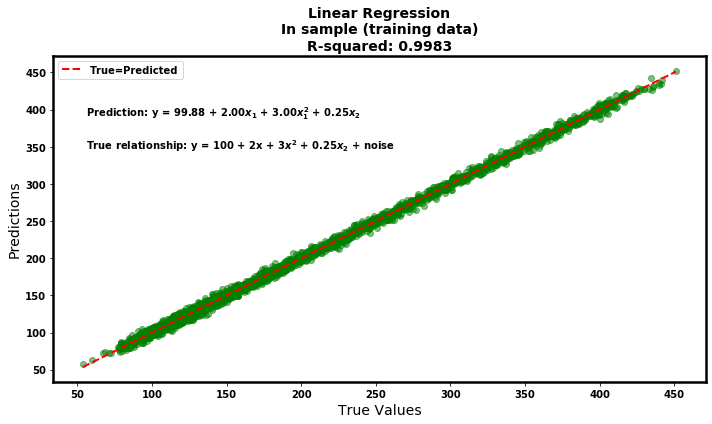

In [31]:
fig, ax =  lr_big_demo.plot_pred_vs_true(model, y_train, X_train_full, feature_names=["$x_1$", "$x_1^2$", "$x_2$"], 
                                         showTrue=True, 
                                         title="Linear Regression\nIn sample (training data)\n")

The weights of the
- prediction equation
- true relationship

are now much closer than with the smaller training dataset.

## Validation and Cross Validation

In our Validation step in the model development above
- we used our test dataset

**But**
- after you use the test dataset
- you are not "allowed" to continue refining the model !
    - the test dataset is a proxy for the future (out of sample)
    - you cannot use future knowledge



This creates a dilemma
- we need to examine out of sample performance while developing a model
- but we are not allowed to use the test dataset as a proxy

### Validation

[Geron notebook on validation](external/PythonDataScienceHandbook/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb#Thinking-about-Model-Validation)

So how can we perform out of sample prediction to evaluate our model ?

- Answer: Split the *training set* into two pieces
    - a smaller training set
    - a *hold-out* piece called the *validation* set
        - the validation set serves a similar role to the test set; it's out of sample
        - it is used to see how well the model generalizes
        - you can use the validation set *many* times (sort of) during your iterative process
            - unlike the test set, which you may look at only once, at the end
   

<table>
 <tr>
        <th><center>Train/Validation/Test split</center></th>
    </tr>
    <tr>
        <td><img src="images/W2_L3_S83_Train_Test_Validation.png"</td>
    </tr>
</table>

### Cross-Validation

Splitting into a smaller training set, and a validation set
-  is a step in the right direction
    - it allows you to evaluate out of sample predictions without peeking into the test set.

You might still be uncomfortable with the idea of a validation set that is used many times.  

Rightly so.
- We can wind up over-fitting to the validation set.  Isn't that cheating too ?

- The validation set is just *one* sample. 
    - How do we know the Performance Measure on this one sample is representative ?
    - Where are the error bars or confidence intervals for this statistic ?
    
Cross-Validation to the rescue !

**K-fold cross-validation**
- Split the training data into $K$ pieces (called *folds*. so K-fold means $K$ pieces).
- Select one fold as the validation set, and use the other $(K-1)$ folds as the smaller training set
    - Fit the model on the smaller training set
    - Evaluate the Performance measure on the fold selected as the validation set
- Repeat the above $(K-1)$ times, using a different fold as the validation set each time.

<table>
 <tr>
        <th><center>Cross Validation/Test split</center></th>
    </tr>
    <tr>
        <td><img src="images/W2_L3_S88_Train_Test_Validation_Fold.png" width="60%"></td>
    </tr>
</table>

Cross validation creates $k$ proxies for the out of sample dataset
- one for each split

This means we don't over fit to a single validation dataset.

But it also gives us a *distribution* of the Performance Metric
- one for each split
- the distribution may be more informative of out of sample performance than a single validation dataset

We can *summarize* the distribution with a single value, if needed (or convenient)
- mean
- 95% confidence
    - This is akin to the statistical confidence interval for in-sample estimators        

The cost of this advantage
- we need to fit the model $k$ times
    - one for each split
- we need to summarize the distribution

This sounds like a lot of work.

Fear not !

sklearn has a function to do this for us: `cross_val_score`

    from sklearn.cross_validation import cross_val_score

    scores = cross_val_score(model, X, y, cv=5)

This will 
- create $k=5$ splits
- train $k$ models
- return an array `score`
    - length $k$
    - one Performance Metric per split


**Note**

`cross_val_score` trains a model on a *subset* ($k-1$ folds) of the training dataset

The state of `model` after this method is called
- is *probably* the model fit on the *last* split

It is used **only** to compute the (distribution) of the Performance Metric !

As a final step:
- fit the model on the *complete* training dataset
- this is the model that you will use for out of sample predicto

The typical work-flow

    scores = cross_val_score(model, X, y, cv=5)
 
    # Train the model using the training sets
    _ = model.fit(X, y)


**In general you should be using Cross Validation in Classical ML** in the absence of a good reason not to !
- helps you determine stability of your model's predictions
- once we get to Deep Learning: 
    - training may be so expensive as to preclude the use of Cross Validation
    
Remember: you still have the Test set as the "gold standard"

# Fine tune

There are often "tweaks" that can be applied to a near-final model in order to squeeze out increase
performance.

For example: many models have *hyper parameters*.

These are values that are *chosen* at model construction, rather than *discovered* by fitting during training ($\Theta$)

- the degree $d$ of the polynomial when constructing higher order features $\x^d$
- whether to include/exclude the intercept $\Theta_0$ in a Linear Regression
- strength of the regularization penalty (coming attraction: to be discussed together with the Loss function)
- the $k$ in K Nearest Neighbors

Perhaps a different choice of a hyper-parameter would improve the model ?

We can try many choices before settling on the one giving the best Performance Metric.

Hyper parameters search is another reason for using Cross Validation
- we can't use the Test set more than once
- with a single Validation set: we might overfit to the validation set
    - that is, choose a value for the hyper parameter that is best for this *single* validation set

We encourage  you to do a Deeper Dive by examining the topic of [Fine Tuning](Fine_tuning.ipynb).

# Recap

- We have briefly detailed the multi-step process for Machine Learning
- This should be a model for you (and your assignments !)
- We will explore some of the steps in greater depth in future modules.

In [32]:
print("Done !")

Done !
